# Set up 

## Check Environment 

In [2]:
import boto3

region = boto3.Session().region_name
session = boto3.session.Session()

ec2 = boto3.Session().client(service_name="ec2", region_name=region)
sm = boto3.Session().client(service_name="sagemaker", region_name=region)

## Update IAM Roles and Policies

In [3]:
import sagemaker
import time
from time import gmtime, strftime

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = 'sagemaker-studio-458903497716-h2kl4ff3dz'
region = boto3.Session().region_name

from botocore.config import Config

config = Config(retries={"max_attempts": 10, "mode": "adaptive"})

iam = boto3.client("iam", config=config)

In [4]:
role_name = role.split("/")[-1]

print("Role name: {}".format(role_name))

Role name: LabRole


## Import Libraries

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
! pip install descartes
! pip install geopandas
import geopandas as gpd
from geopandas import GeoDataFrame, points_from_xy

# Create Database Schema in Athena

In [6]:
import boto3
import sagemaker

sess = sagemaker.Session()
bucket = 'sagemaker-studio-458903497716-h2kl4ff3dz'
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

In [7]:
print(bucket)

sagemaker-studio-458903497716-h2kl4ff3dz


In [8]:
!pip install --disable-pip-version-check -q PyAthena==2.1.0
from pyathena import connect

In [9]:
#assign database name
database_name = "ads508"

In [10]:
# Set S3 staging directory -- this is a temporary directory used for Athena queries
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

In [11]:
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

In [12]:
#create new database 'ads508'
statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)
create_db = pd.read_sql(statement, conn)
create_db

""


In [13]:
#verify database creation
q = "SHOW DATABASES"
db_show = pd.read_sql(q, conn)
db_show

,database_name
0,ads508
1,default
2,dsoaws


## Create Athena Table

In [19]:
# Set Athena parameters
database_name = "ads508"
table_name_csv = "gun_violence"
s3_path = "s3://{}/data".format(bucket)
print(s3_path)

s3://sagemaker-studio-458903497716-h2kl4ff3dz/data


In [22]:
statement = """ DROP TABLE ads508.gun_violence_csv"""
execute=pd.read_sql(statement, conn)

In [24]:
# SQL statement to execute
statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
         incident_id int,
         date date,
         state string,
         city_or_county string,
         address string,
         n_killed int,
         n_injured int,
         incident_url string,
         source_url string,
         incident_url_fields_missing string,
         congressional_district int,
         gun_stolen string,
         gun_type string,
         incident_characteristics string,
         latitude int,
         location_description string,
         longitude int,
         n_guns_involved int,
         notes string,
         participant_age string,
         participant_age_group string,
         participant_gender string,
         participant_name string,
         participant_relationship string,
         participant_status string,
         participant_type string,
         sources string,
         state_house_district int,
         state_senate_district int
) ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' LINES TERMINATED BY '\\n' LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name_csv, s3_path
)

create_table = pd.read_sql(statement, conn)
create_table

""


In [25]:
statement = "SHOW TABLES in ads508"
tables = pd.read_sql(statement, conn)
tables

,tab_name
0,gun_violence


In [28]:
statement = "SELECT * from ads508.gun_violence LIMIT 100"
df = pd.read_sql(statement, conn)
df.head(5)

,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,incident_url_fields_missing,...,participant_age,participant_age_group,participant_gender,participant_name,participant_relationship,participant_status,participant_type,sources,state_house_district,state_senate_district
0,905425.0,2017-08-02,Pennsylvania,Johnstown,900 block of Steel St,1.0,0.0,http://www.gunviolencearchive.org/incident/905425,http://www.tribdem.com/news/police-seek-person...,False,...,1,,0::19||1::22,0::Adult 18+||1::Adult 18+,0::Male||1::Male,0::Luke J. Yuzwa||1::Tyrone Terrance McDuffie,,0::Killed||1::Arrested,NaN,NaN
1,904930.0,2017-08-02,Kansas,Topeka,2854 SE Highland Ct,0.0,3.0,http://www.gunviolencearchive.org/incident/904930,http://cjonline.com/news/local/crime-courts/20...,False,...,0::38||1::39||2::15,0::Adult 18+||1::Adult 18+||2::Teen 12-17,0::Male||1::Female||2::Male,0::Virgil Moppin||1::Andrea Carter||2::Colin M...,,0::Injured||1::Injured||2::Injured,0::Victim||1::Victim||2::Victim,http://www.wibw.com/content/news/3-people-take...,57.0,19.0
2,906530.0,2017-08-02,Georgia,Warner Robins,1310 Green St,0.0,0.0,http://www.gunviolencearchive.org/incident/906530,http://www.macon.com/news/local/crime/article1...,False,...,0::19,0::Adult 18+,0::Female,0::Aniya Green,,"""0::Unharmed","Arrested""",0::Subject-Suspect,NaN,147.0
3,905777.0,2017-08-02,Ohio,Toledo,2800 block of Lagrange St,0.0,1.0,http://www.gunviolencearchive.org/incident/905777,http://www.toledoblade.com/Police-Fire/2017/08...,False,...,0::35,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||2::Male||3::Male,0::Anthony Woods,,0::Injured||1::Unharmed||2::Unharmed||3::Unharmed,0::Victim||1::Subject-Suspect||2::Subject-Susp...,http://www.toledoblade.com/Police-Fire/2017/08...,44.0,11.0
4,904968.0,2017-08-02,Virginia,Newport News,3700 block of Marshall Ave,0.0,1.0,http://www.gunviolencearchive.org/incident/904968,http://www.dailypress.com/news/newport-news/dp...,False,...,0::30,0::Adult 18+,0::Male,,,0::Injured,0::Victim,http://www.dailypress.com/news/newport-news/dp...,95.0,2.0


# Insert Dataset into Pandas Dataframe

In [33]:
df = pd.read_csv("s3://sagemaker-studio-458903497716-h2kl4ff3dz/data/gun_violence.csv")
df.head()

,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,incident_url_fields_missing,...,participant_age,participant_age_group,participant_gender,participant_name,participant_relationship,participant_status,participant_type,sources,state_house_district,state_senate_district
0,461105,2013-01-01,Pennsylvania,Mckeesport,1506 Versailles Avenue and Coursin Street,0,4,http://www.gunviolencearchive.org/incident/461105,http://www.post-gazette.com/local/south/2013/0...,False,...,0::20,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||3::Male||4::Female,0::Julian Sims,NaN,0::Arrested||1::Injured||2::Injured||3::Injure...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://pittsburgh.cbslocal.com/2013/01/01/4-pe...,NaN,NaN
1,460726,2013-01-01,California,Hawthorne,13500 block of Cerise Avenue,1,3,http://www.gunviolencearchive.org/incident/460726,http://www.dailybulletin.com/article/zz/201301...,False,...,0::20,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male,0::Bernard Gillis,NaN,0::Killed||1::Injured||2::Injured||3::Injured,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://losangeles.cbslocal.com/2013/01/01/man-...,62.0,35.0
2,478855,2013-01-01,Ohio,Lorain,1776 East 28th Street,1,3,http://www.gunviolencearchive.org/incident/478855,http://chronicle.northcoastnow.com/2013/02/14/...,False,...,0::25||1::31||2::33||3::34||4::33,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||2::Male||3::Male||4::Male,0::Damien Bell||1::Desmen Noble||2::Herman Sea...,NaN,"0::Injured, Unharmed, Arrested||1::Unharmed, A...",0::Subject-Suspect||1::Subject-Suspect||2::Vic...,http://www.morningjournal.com/general-news/201...,56.0,13.0
3,478925,2013-01-05,Colorado,Aurora,16000 block of East Ithaca Place,4,0,http://www.gunviolencearchive.org/incident/478925,http://www.dailydemocrat.com/20130106/aurora-s...,False,...,0::29||1::33||2::56||3::33,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Female||1::Male||2::Male||3::Male,0::Stacie Philbrook||1::Christopher Ratliffe||...,NaN,0::Killed||1::Killed||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,http://denver.cbslocal.com/2013/01/06/officer-...,40.0,28.0
4,478959,2013-01-07,North Carolina,Greensboro,307 Mourning Dove Terrace,2,2,http://www.gunviolencearchive.org/incident/478959,http://www.journalnow.com/news/local/article_d...,False,...,0::18||1::46||2::14||3::47,0::Adult 18+||1::Adult 18+||2::Teen 12-17||3::...,0::Female||1::Male||2::Male||3::Female,0::Danielle Imani Jameison||1::Maurice Eugene ...,3::Family,0::Injured||1::Injured||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,http://myfox8.com/2013/01/08/update-mother-sho...,62.0,27.0


In [34]:
print(df.shape)

(239677, 29)


### The dataset contains 23,9677 rows and 29 attributes. 

## Show null values

In [35]:
df.isnull().sum()

incident_id                         0
date                                0
state                               0
city_or_county                      0
address                         16497
n_killed                            0
n_injured                           0
incident_url                        0
source_url                        468
incident_url_fields_missing         0
congressional_district          11944
gun_stolen                      99498
gun_type                        99451
incident_characteristics          326
latitude                         7923
location_description           197588
longitude                        7923
n_guns_involved                 99451
notes                           81017
participant_age                 92298
participant_age_group           42119
participant_gender              36362
participant_name               122253
participant_relationship       223903
participant_status              27626
participant_type                24863
sources     

## Show percentage of null values

In [36]:
rows = len(df.index)
print ("address: " + str(round(((16497/rows)*100),2)) + "%")
print ("source_url: " + str(round(((468/rows)*100),2)) + "%")
print ("congressional district: " + str(round(((11944/rows)*100),2)) + "%")
print ("gun_stolen: " + str(round(((99498/rows)*100),2)) + "%")
print ("gun_type: " + str(round(((99451/rows)*100),2)) + "%")
print ("incident_characteristics: " + str(round(((326/rows)*100),2)) + "%")
print ("latitude: " + str(round(((7923/rows)*100),2)) + "%")
print ("location_description: " + str(round(((197588/rows)*100),2)) + "%")
print ("longitude: " + str(round(((7923/rows)*100),2)) + "%")
print ("n_guns_involved: " + str(round(((99451/rows)*100),2)) + "%")
print ("notes: " + str(round(((81017/rows)*100),2)) + "%")
print ("participant_age: " + str(round(((92298/rows)*100),2)) + "%")
print ("participant_age_group: " + str(round(((42119/rows)*100),2)) + "%")
print ("participant_gender: " + str(round(((36362/rows)*100),2)) + "%")
print ("participant_name: " + str(round(((122253/rows)*100),2)) + "%")
print ("participant_relationship: " + str(round(((223903/rows)*100),2)) + "%")
print ("participant_status: " + str(round(((27626/rows)*100),2)) + "%")
print ("participant_type: " + str(round(((24863/rows)*100),2)) + "%")
print ("sources: " + str(round(((609/rows)*100),2)) + "%")
print ("state_house_district: " + str(round(((38772/rows)*100),2)) + "%")
print ("state_senate_district: " + str(round(((32335/rows)*100),2)) + "%")


address: 6.88%
source_url: 0.2%
congressional district: 4.98%
gun_stolen: 41.51%
gun_type: 41.49%
incident_characteristics: 0.14%
latitude: 3.31%
location_description: 82.44%
longitude: 3.31%
n_guns_involved: 41.49%
notes: 33.8%
participant_age: 38.51%
participant_age_group: 17.57%
participant_gender: 15.17%
participant_name: 51.01%
participant_relationship: 93.42%
participant_status: 11.53%
participant_type: 10.37%
sources: 0.25%
state_house_district: 16.18%
state_senate_district: 13.49%


## Show data types

In [37]:
df.dtypes

incident_id                      int64
date                            object
state                           object
city_or_county                  object
address                         object
n_killed                         int64
n_injured                        int64
incident_url                    object
source_url                      object
incident_url_fields_missing       bool
congressional_district         float64
gun_stolen                      object
gun_type                        object
incident_characteristics        object
latitude                       float64
location_description            object
longitude                      float64
n_guns_involved                float64
notes                           object
participant_age                 object
participant_age_group           object
participant_gender              object
participant_name                object
participant_relationship        object
participant_status              object
participant_type         

# Use GeoPandas to map all gun violence incidences

In [46]:
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [47]:
# wrap df w/ a GeoDataFrame by creating a geometry attribute
df_geo = GeoDataFrame(df, geometry=points_from_xy(df.longitude, df.latitude))
df_geo.head()

,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,incident_url_fields_missing,...,participant_age_group,participant_gender,participant_name,participant_relationship,participant_status,participant_type,sources,state_house_district,state_senate_district,geometry
0,461105,2013-01-01,Pennsylvania,Mckeesport,1506 Versailles Avenue and Coursin Street,0,4,http://www.gunviolencearchive.org/incident/461105,http://www.post-gazette.com/local/south/2013/0...,False,...,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||3::Male||4::Female,0::Julian Sims,NaN,0::Arrested||1::Injured||2::Injured||3::Injure...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://pittsburgh.cbslocal.com/2013/01/01/4-pe...,NaN,NaN,POINT (-79.85590 40.34670)
1,460726,2013-01-01,California,Hawthorne,13500 block of Cerise Avenue,1,3,http://www.gunviolencearchive.org/incident/460726,http://www.dailybulletin.com/article/zz/201301...,False,...,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male,0::Bernard Gillis,NaN,0::Killed||1::Injured||2::Injured||3::Injured,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://losangeles.cbslocal.com/2013/01/01/man-...,62.0,35.0,POINT (-118.33300 33.90900)
2,478855,2013-01-01,Ohio,Lorain,1776 East 28th Street,1,3,http://www.gunviolencearchive.org/incident/478855,http://chronicle.northcoastnow.com/2013/02/14/...,False,...,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||2::Male||3::Male||4::Male,0::Damien Bell||1::Desmen Noble||2::Herman Sea...,NaN,"0::Injured, Unharmed, Arrested||1::Unharmed, A...",0::Subject-Suspect||1::Subject-Suspect||2::Vic...,http://www.morningjournal.com/general-news/201...,56.0,13.0,POINT (-82.13770 41.44550)
3,478925,2013-01-05,Colorado,Aurora,16000 block of East Ithaca Place,4,0,http://www.gunviolencearchive.org/incident/478925,http://www.dailydemocrat.com/20130106/aurora-s...,False,...,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Female||1::Male||2::Male||3::Male,0::Stacie Philbrook||1::Christopher Ratliffe||...,NaN,0::Killed||1::Killed||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,http://denver.cbslocal.com/2013/01/06/officer-...,40.0,28.0,POINT (-104.80200 39.65180)
4,478959,2013-01-07,North Carolina,Greensboro,307 Mourning Dove Terrace,2,2,http://www.gunviolencearchive.org/incident/478959,http://www.journalnow.com/news/local/article_d...,False,...,0::Adult 18+||1::Adult 18+||2::Teen 12-17||3::...,0::Female||1::Male||2::Male||3::Female,0::Danielle Imani Jameison||1::Maurice Eugene ...,3::Family,0::Injured||1::Injured||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,http://myfox8.com/2013/01/08/update-mother-sho...,62.0,27.0,POINT (-79.95690 36.11400)


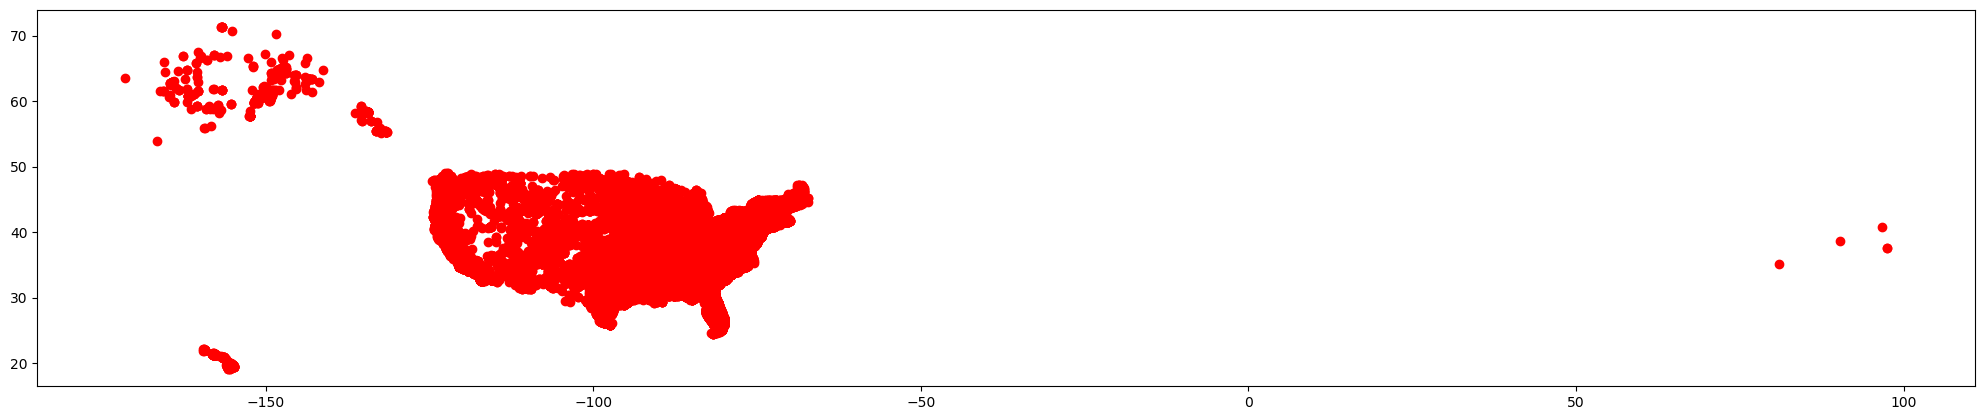

In [52]:
plt.rcParams['figure.figsize'] = [25,25]
df_geo.plot(color='red')
plt.show()

### There are 4 incidences that appear around latitide 40 longitude 100 that appear outside the US. We will explore these further.

In [63]:
statement = """SELECT * FROM ads508.gun_violence WHERE longitude BETWEEN 80 and 100 LIMIT 10"""
execute=pd.read_sql(statement, conn)
execute.head()

,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,incident_url_fields_missing,...,participant_age,participant_age_group,participant_gender,participant_name,participant_relationship,participant_status,participant_type,sources,state_house_district,state_senate_district
0,989590,2017-11-15,Missouri,St Louis,,0,0,http://www.gunviolencearchive.org/incident/989590,http://stlouis.cbslocal.com/2017/11/15/update-...,False,...,,,,,,,,http://stlouis.cbslocal.com/2017/11/15/update-...,None,None
1,1012331,2017-12-22,North Carolina,Charlotte,,0,0,http://www.gunviolencearchive.org/incident/101...,http://wlos.com/news/local/tsa-seizes-another-...,False,...,,,,,,,,http://wlos.com/news/local/tsa-seizes-another-...,None,None
2,1075419,2018-03-20,Nebraska,Lincoln,,0,0,http://www.gunviolencearchive.org/incident/107...,http://www.1011now.com/content/news/Handgun-fo...,False,...,,,,,,,,http://www.1011now.com/content/news/Handgun-fo...,None,None
3,1081194,2018-03-25,Kansas,Wichita,,0,0,http://www.gunviolencearchive.org/incident/108...,http://www.kansas.com/news/local/crime/article...,False,...,,,,,,,,http://www.kansas.com/news/local/crime/article...,None,None
4,1081193,2018-03-29,Kansas,Wichita,,0,0,http://www.gunviolencearchive.org/incident/108...,http://www.kansas.com/news/local/crime/article...,False,...,,,,,,,,http://www.kansas.com/news/local/crime/article...,None,None


It seems that these extries did appear in the US (specifically in N. Carolina, Nebraska, Kansas, and Missouri). Maybe something went wrong during mapping? 

/opt/conda/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


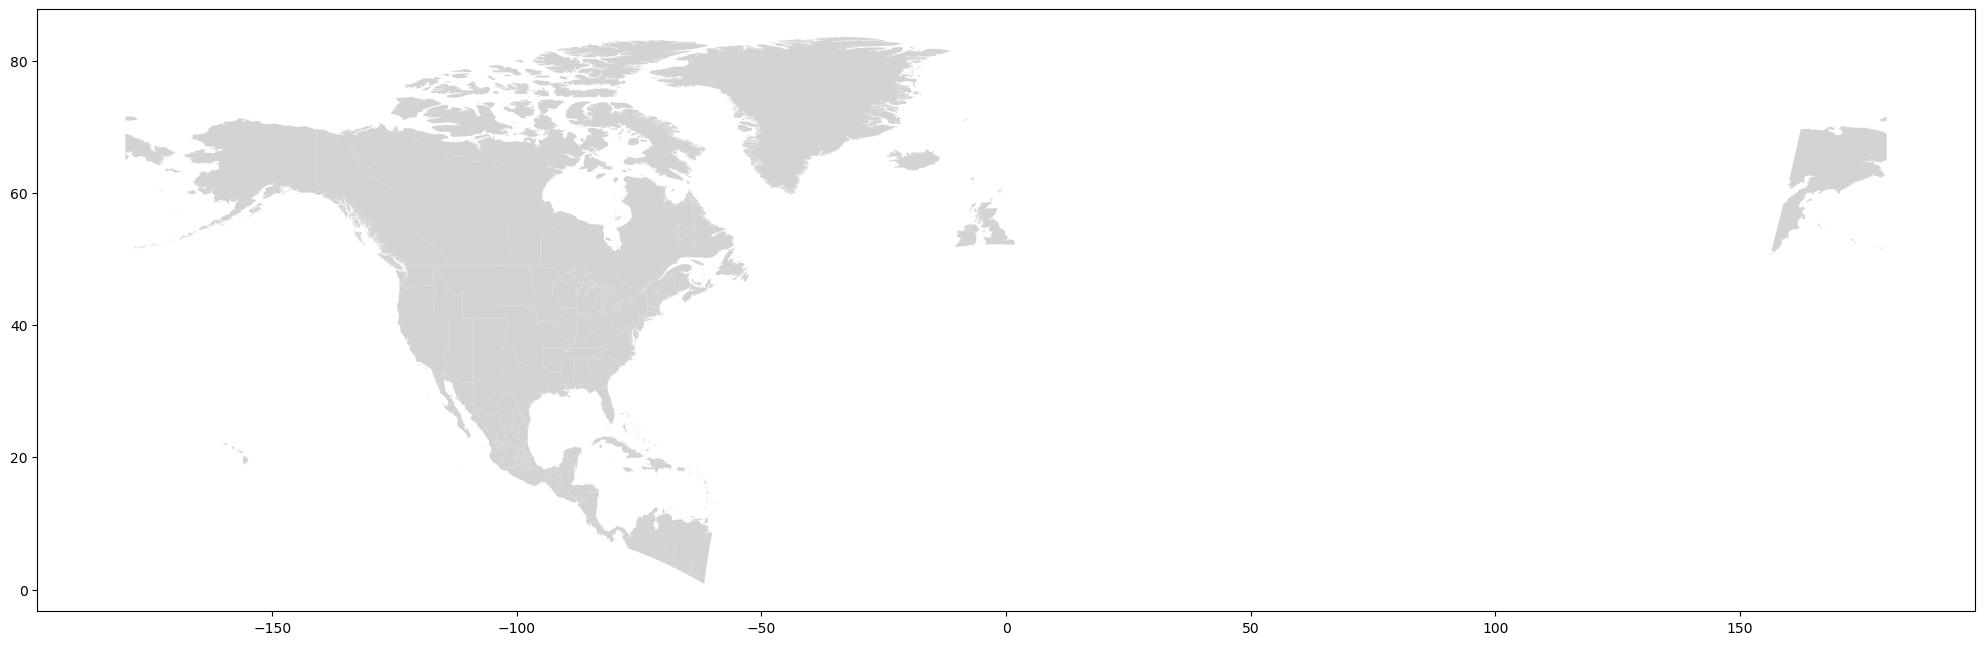

In [58]:
north_america = GeoDataFrame.from_file('north_america_shapefile/')
north_america.plot(color='lightgrey')
plt.show()

/opt/conda/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


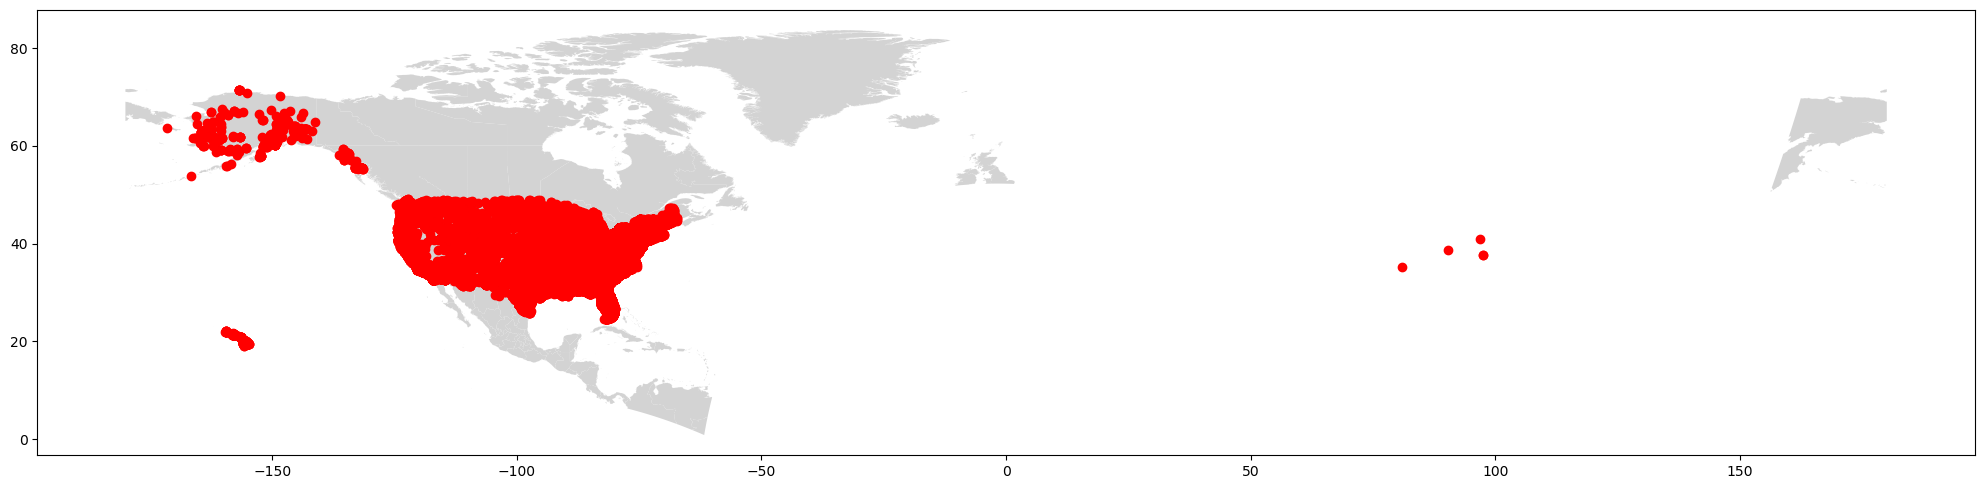

In [62]:
axes = north_america.plot(color='lightgrey')
df_geo.plot(ax=axes, color='red')
plt.show()